In [1]:
#Hyperparameters:

SHOULD_USE_SEED = True
RADIUS = 10000
BATCH_SIZE = 700
EPSILON = 0.1
SIGMA = 0.0001
MAX_ITERS = 100


In [2]:
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import numpy as np

from data.data_creator import data_create_Rotten_Tomatoes

if SHOULD_USE_SEED:
    np.random.seed(42)


## Dataset 

In [3]:
data, labels = data_create_Rotten_Tomatoes()

print("Example for a movie review from rotten tomatoes: ", data[0])
print("Number of instances in the database: ", len(data))

Example for a movie review from rotten tomatoes:  simplistic , silly and tedious .
Number of instances in the database:  10662


In [4]:
#Splitting the dataset
x_train_all, x_test, y_train_all, y_test = train_test_split(
    data, labels, test_size=.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_all, y_train_all, test_size=.1, random_state=42)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

## Black-box model - Multinomial Naive Bayes classifier

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect_text = TfidfVectorizer(use_idf = False)
x_vec_train = vect_text.fit_transform(x_train)

clf = MultinomialNB().fit(x_vec_train, y_train)

In [6]:
preds = clf.predict(vect_text.transform(x_val))

In [7]:
print('Val accuracy', metrics.accuracy_score(y_val, preds))

Val accuracy 0.7584994138335287


## Instance to explain

In [8]:
x_explain = x_test[1]#"the movie's thesis -- elegant technology for the masses -- is surprisingly refreshing ."
print('x to explain: ',x_explain)
print('Predicted class: ', clf.predict(vect_text.transform([x_explain]))[0])
print('True class: ', y_test[1])
print('Predict probablilities: ', clf.predict_proba(vect_text.transform([x_explain]))[0])


x to explain:  the movie's thesis -- elegant technology for the masses -- is surprisingly refreshing .
Predicted class:  1
True class:  1
Predict probablilities:  [0.29029215 0.70970785]


## Building MeLime model:

In [9]:
import nltk
from torch.utils.data import DataLoader
def tokenizer(x):
    return x.split()
dl_train = [tokenizer(x) for x in x_train]

In [10]:
from gen_models.word2vec_gen import Word2VecGen, Word2VecEncoder
#The radius is <radius> most similar words
generator = Word2VecGen(encoder = Word2VecEncoder(dl_train), corpus = x_train, radius = RADIUS, tokenizer = tokenizer)

In [11]:
from interpretable_local_models.statistics_model import StatisticsLocalModel
tokenized_x_explain = x_explain.split()
y_p_explain = max(clf.predict_proba(vect_text.transform([x_explain]))[0])
explainer_model = StatisticsLocalModel(y_p_explain, len(tokenized_x_explain), tokenizer)
print(tokenized_x_explain)

['the', "movie's", 'thesis', '--', 'elegant', 'technology', 'for', 'the', 'masses', '--', 'is', 'surprisingly', 'refreshing', '.']


In [12]:
from MeLime.model import MeLimeModel

def transform_func(x):
    return vect_text.transform([x])

model = MeLimeModel(black_box_model = clf,gen_model =generator, batch_size = BATCH_SIZE, epsilon_c = EPSILON, 
                    sigma = SIGMA, explainer_model = explainer_model, transform_func = transform_func, 
                    max_iters = MAX_ITERS, tokenizer = tokenizer)

## Explaining the instance

In [13]:
res, sentences_with_probs = model.forward(x_explain)

Iteration number:  3
Delta:  0.0038270054819197377
Iteration number:  6
Delta:  0.0007248350372431033
Iteration number:  9
Delta:  0.0002929868400044249
Iteration number:  12
Delta:  0.0004089576657791627
Iteration number:  15
Delta:  0.00013287033526322465
Iteration number:  18
Delta:  8.884266002469209e-05


## Plotting results

/home/ortalcohen/NLP-Project/NLP-Seminar/interpretable_local_models/statistics_model.py:72: RuntimeWarning: invalid value encountered in double_scalars
  x = x / abs(x) * 0.10


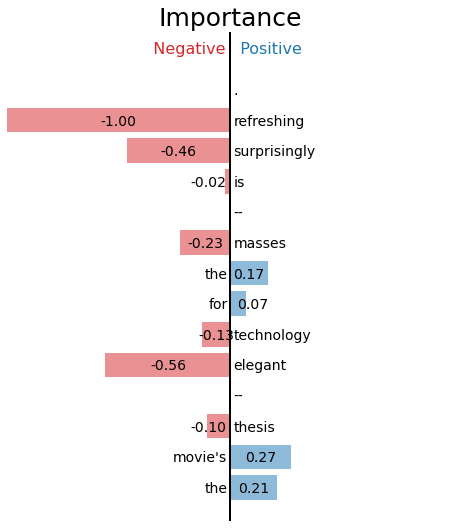

In [14]:
ax = StatisticsLocalModel.plot_explaination(res)


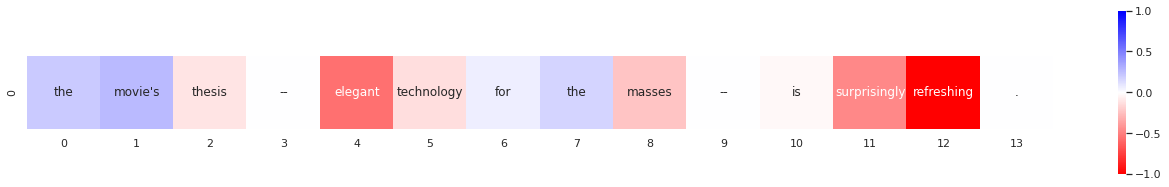

In [15]:
import seaborn as sns
StatisticsLocalModel.plot_sentence_heatmap(res)

## Plotting most favorable and contrary samples phrases:

Favorable sentence - a generated sentence using Word2VecGen that improves the model's confidence in its 
prediction on the original sentence.

Contrary samples - a generated sentence using Word2VecGen that decrease the model's confidence in its prediction on the original sentence and <b>might even change its prediction on the generated sentence</b>.

### Most contrary samples phrases:



In [16]:
sorted(sentences_with_probs, key = lambda x: x[1])[:5]

[("the movie's thesis -- elegant technology for the masses -- is surprisingly generic .",
  0.5025889567695815),
 ("the movie's thesis -- elegant technology for the masses -- is surprisingly episode .",
  0.5248593721754765),
 ("the movie's thesis -- elegant technology for the masses -- is surprisingly suffers .",
  0.5281083223830958),
 ("the movie's thesis -- elegant technology for the masses -- is surprisingly heavy .",
  0.5298123619928775),
 ("the movie's thesis -- elegant technology for the masses -- is surprisingly unnecessary .",
  0.5385807647006947)]

### Most favorable samples phrases:

In [17]:
sorted(sentences_with_probs, key = lambda x: x[1], reverse = True)[:5]

[("the movie's thesis -- elegant technology for engrossing masses -- is surprisingly refreshing .",
  0.8176665527615279),
 ("the movie's thesis -- elegant technology for culture masses -- is surprisingly refreshing .",
  0.8158404475561319),
 ("the movie's thesis -- elegant technology for portrait masses -- is surprisingly refreshing .",
  0.8138416617347014),
 ('the portrait thesis -- elegant technology for the masses -- is surprisingly refreshing .',
  0.8132866789908577),
 ('the provides thesis -- elegant technology for the masses -- is surprisingly refreshing .',
  0.8077252490956566)]